# Task 2

## Predictive modeling of customer bookings

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [87]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler



from scipy.stats import chi2_contingency, f_oneway


In [88]:
df = pd.read_csv("data/customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [90]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [91]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [92]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [93]:
df.describe(include='object')

,sales_channel,trip_type,route,booking_origin
count,50000,50000,50000,50000
unique,2,3,799,104
top,Internet,RoundTrip,AKLKUL,Australia
freq,44382,49497,2680,17872


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

In [94]:
df.columns

Index(['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead',
       'length_of_stay', 'flight_hour', 'flight_day', 'route',
       'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat',
       'wants_in_flight_meals', 'flight_duration', 'booking_complete'],
      dtype='object')

Performing Statistical Analysis to study relationship of columns with the target variable (booking_confirmed)

In [95]:
# Define categorical and numerical columns
categorical_cols = ['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin']
numerical_cols = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 
                  'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 
                  'flight_duration']

# Perform ANOVA for numerical columns
anova_results = {}
for col in numerical_cols:
    groups = []
    for value in df['booking_complete'].unique():
        groups.append(df[df['booking_complete'] == value][col])
    f_statistic, p_value = f_oneway(*groups)
    anova_results[col] = (f_statistic, p_value)

print("ANOVA test results:")
for col, (f_statistic, p_value) in anova_results.items():
    print(f"{col}: F-statistic = {f_statistic}, p-value = {p_value}")

# Perform chi-square test for categorical columns
chi2_results = {}
for col in categorical_cols:
    contingency_table = pd.crosstab(df[col], df['booking_complete'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    chi2_results[col] = (chi2, p)

print("\nChi-square test results:")
for col, (chi2, p) in chi2_results.items():
    print(f"{col}: Chi-square = {chi2}, p-value = {p}")


ANOVA test results:
num_passengers: F-statistic = 29.095371235389326, p-value = 6.921342270272393e-08
purchase_lead: F-statistic = 24.499494463169036, p-value = 7.457066331808997e-07
length_of_stay: F-statistic = 90.08025320344103, p-value = 2.3836439466659255e-21
flight_hour: F-statistic = 2.539951241583847, p-value = 0.11100453516150224
wants_extra_baggage: F-statistic = 233.21633189748334, p-value = 1.5584330370735617e-52
wants_preferred_seat: F-statistic = 125.89163177408827, p-value = 3.5191689311247533e-29
wants_in_flight_meals: F-statistic = 35.164462901792625, p-value = 3.049870065181525e-09
flight_duration: F-statistic = 571.050238821459, p-value = 1.6831449986832256e-125

Chi-square test results:
sales_channel: Chi-square = 83.93114914857576, p-value = 5.123094421404519e-20
trip_type: Chi-square = 39.88685806860332, p-value = 2.181116284042331e-09
flight_day: Chi-square = 16.108133180759424, p-value = 0.013185192051000813
route: Chi-square = 5907.13518148551, p-value = 0.0
bo

### ANOVA Test Results:

Significant predictors of booking completion:
num_passengers, purchase_lead, length_of_stay, wants_extra_baggage, wants_preferred_seat, wants_in_flight_meals, and flight_duration.
Non-significant predictors:
flight_hour.

### Chi-square Test Results:

Significant predictors of booking completion:
sales_channel, trip_type, route, and booking_origin.

### Marginally significant predictor:

flight_day.

### Summary:

In summary, the number of passengers, purchase lead time, length of stay, preferences for extra baggage, preferred seats, in-flight meals, and flight duration significantly influence booking completion. Similarly, the choice of sales channel, trip type, flight route, and booking origin are significant factors affecting booking completion. However, the day of the flight has a less pronounced but still noticeable impact on booking completion.

# Building Model

In [96]:
# Step 1: Encoding Categorical Variables with Label Encoding
label_encoder = LabelEncoder()
X_categorical = df[categorical_cols].apply(label_encoder.fit_transform)

# Combine numerical and encoded categorical features
numerical_cols = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 
                  'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 
                  'flight_duration']

X_numerical = df[numerical_cols]

X = pd.concat([X_numerical, X_categorical], axis=1)

# Step 2: Splitting the Data into Features (X) and Target (y)
y = df['booking_complete']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Now, X_train and X_test contain the features, and y_train and y_test contain the target variable.


Cross-Validation Mean Accuracy: 0.8515499999999999
Test Accuracy: 0.8536
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      8504
           1       0.56      0.10      0.17      1496

    accuracy                           0.85     10000
   macro avg       0.71      0.54      0.54     10000
weighted avg       0.82      0.85      0.81     10000



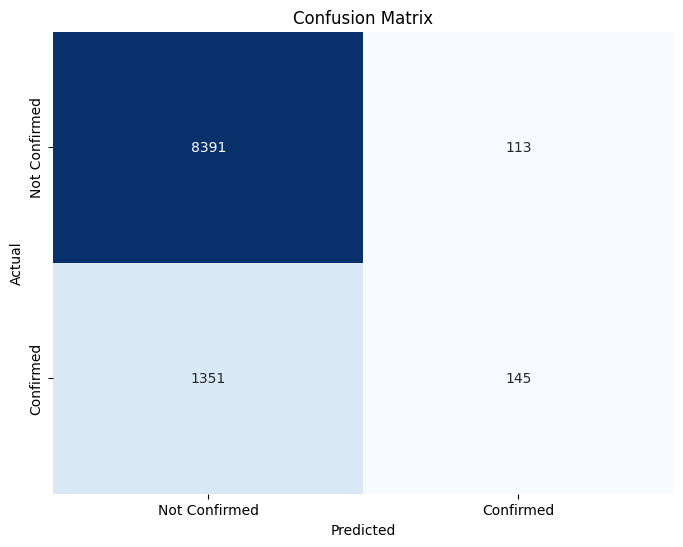

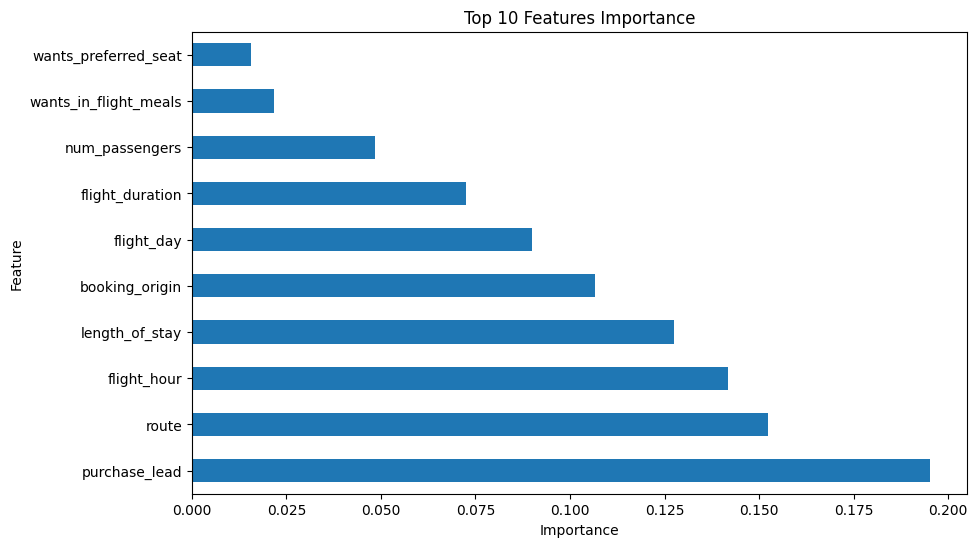

In [101]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize RandomForest classifier
rf_clf = RandomForestClassifier(random_state=42)

# Train the classifier
rf_clf.fit(X_train, y_train)

# Perform cross-validation
cv_scores = cross_val_score(rf_clf, X_train, y_train, cv=5)

# Evaluate model performance
y_pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Cross-Validation Mean Accuracy:", cv_scores.mean())
print("Test Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Not Confirmed', 'Confirmed'], 
            yticklabels=['Not Confirmed', 'Confirmed'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot variable importance
plt.figure(figsize=(10, 6))
feat_importances = pd.Series(rf_clf.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Features Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


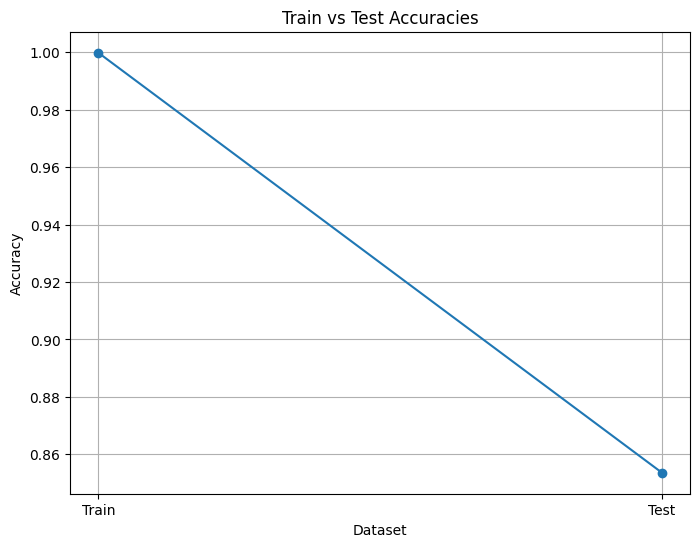

In [102]:
# Calculate train and test accuracies
train_accuracy = rf_clf.score(X_train, y_train)
test_accuracy = rf_clf.score(X_test, y_test)

# Plot train and test accuracies
plt.figure(figsize=(8, 6))
plt.plot([1, 2], [train_accuracy, test_accuracy], marker='o')
plt.xticks([1, 2], ['Train', 'Test'])
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracies')
plt.grid(True)
plt.show()

Cross-Validation Mean Accuracy: 0.5745726378492444
Test Accuracy: 0.9998
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8504
           1       1.00      1.00      1.00      1496

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



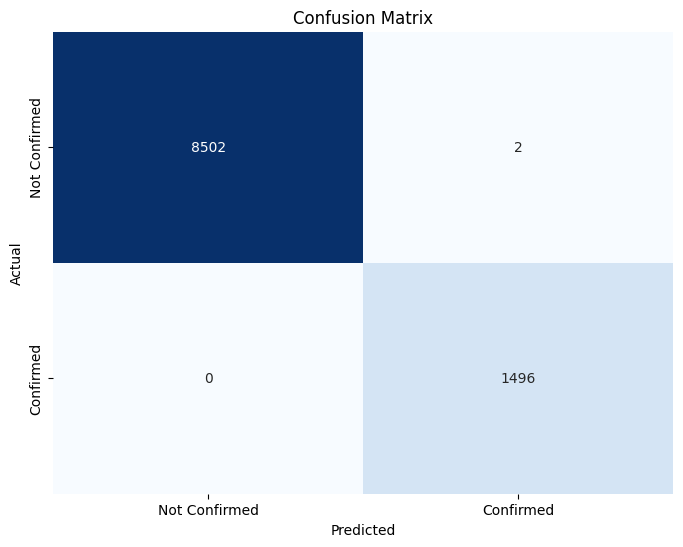

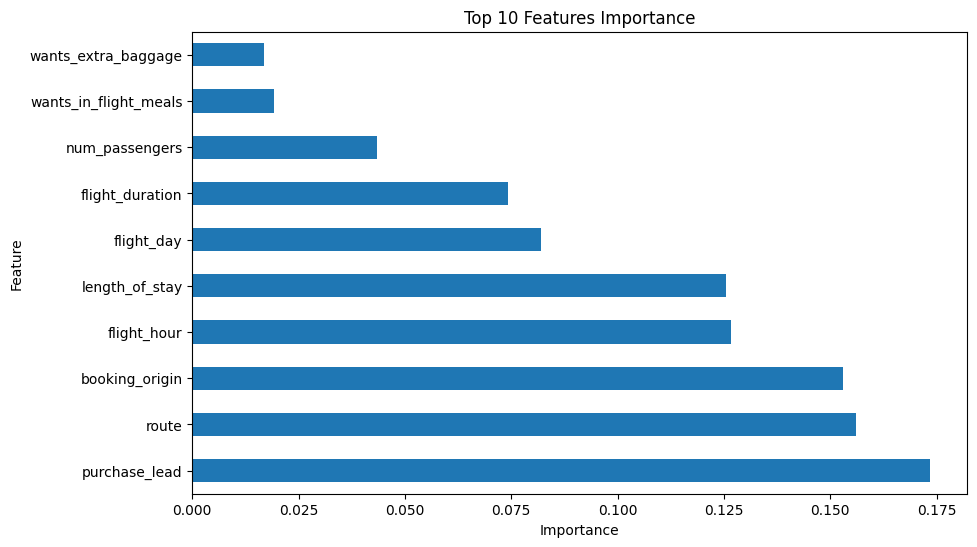

In [104]:
# Initialize RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Resample the data
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Initialize RandomForest classifier
rf = RandomForestClassifier(random_state=42)

# Train the classifier
rf.fit(X_resampled, y_resampled)

# Perform cross-validation
cv_scores = cross_val_score(rf, X_resampled, y_resampled, cv=5)

# Evaluate model performance
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Cross-Validation Mean Accuracy:", cv_scores.mean())
print("Test Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Not Confirmed', 'Confirmed'], 
            yticklabels=['Not Confirmed', 'Confirmed'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot variable importance
plt.figure(figsize=(10, 6))
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Features Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


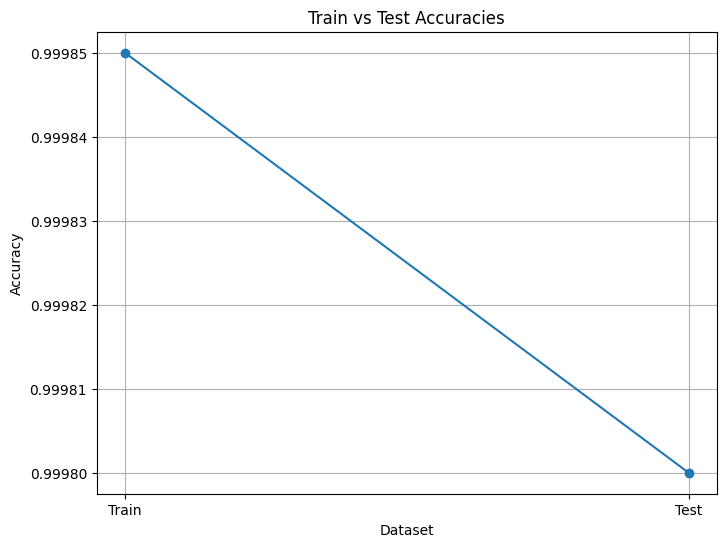

In [105]:
# Calculate train and test accuracies
train_accuracy = rf.score(X_train, y_train)
test_accuracy = rf.score(X_test, y_test)

# Plot train and test accuracies
plt.figure(figsize=(8, 6))
plt.plot([1, 2], [train_accuracy, test_accuracy], marker='o')
plt.xticks([1, 2], ['Train', 'Test'])
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracies')
plt.grid(True)
plt.show()
